# Setup

In [1]:
import ugradio
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import lstsq, inv, norm
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy.stats import norm, linregress
from scipy.optimize import curve_fit, least_squares
from scipy.signal import find_peaks, stft
from scipy.special import j1
from uncertainties import ufloat
import os
import glob
import time
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

No module named 'rtlsdr'


In [2]:
# Consistent Plot Params
titleSize = 15
axisSize = 15
legendSize = 13
graphSizeSingle = (8, 6)
graphSizeDouble = (15, 6)
graphSizeHorizontal = (20, 6)

# Data Extraction

In [ ]:
class pointData:
    def __init__(self, l=0, b=0, online=None, offline=None, calibration=None, sdr_index):
        self.l = l
        self.b = b
        self.online = online
        self.offline = offline
        self.cal = calibration
        self.sdr = sdr_index

def extractSdrCalData(sdr_0_paths, sdr_0_cal_paths, sdr_1_paths, sdr_1_cal_paths, normalize=True, pickling=False):
    prefix = "ugastro\\Lab4Data\\"
    sdr_data, cal_data = [[], []], [[], []]
    if normalize:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(subtractMean(np.load(prefix+path_0, allow_pickle=pickling)))
            sdr_data[1].append(subtractMean(np.load(prefix+path_1, allow_pickle=pickling)))

        for path_0, path_1 in zip(sdr_0_cal_paths, sdr_1_cal_paths):
            cal_data[0].append(subtractMean(np.load(prefix+path_0, allow_pickle=pickling)))
            cal_data[1].append(subtractMean(np.load(prefix+path_1, allow_pickle=pickling)))
    else:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(np.load(prefix+path_0, allow_pickle=pickling))
            sdr_data[1].append(np.load(prefix+path_1, allow_pickle=pickling))

        for path_0, path_1 in zip(sdr_0_cal_paths, sdr_1_cal_paths):
            cal_data[0].append(np.load(prefix+path_0, allow_pickle=pickling))
            cal_data[1].append(np.load(prefix+path_1, allow_pickle=pickling))
    return sdr_data, cal_data

def extractSdrData(sdr_0_paths, sdr_1_paths, normalize=False, pickling=False):
    prefix = "ugastro\\Lab4Data\\"
    sdr_data = [[], []]
    if normalize:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(subtractMean(np.load(prefix+path_0, allow_pickle=pickling)))
            sdr_data[1].append(subtractMean(np.load(prefix+path_1, allow_pickle=pickling)))
    else:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(np.load(prefix+path_0, allow_pickle=pickling))
            sdr_data[1].append(np.load(prefix+path_1, allow_pickle=pickling))
    return sdr_data

def extractSdrCal

def subtractMean(data):
    return data - np.mean(data)


In [ ]:
# First attempt at (l, b) = (120, 0)
sdr_0_prefix, sdr_1_prefix = "pol0\\", "pol1\\"
paths = [
    "obs_0_science.npy",
    "obs_1_science.npy",
    "obs_2_science.npy",
    "obs_3_science.npy",
    "obs_4_science.npy"
]
cal_paths = [
    "obs_0_cal_on.npy",
    "obs_4_cal_on.npy"
]

sdr_0_paths = [sdr_0_prefix + path for path in paths]
sdr_1_paths = [sdr_1_prefix + path for path in paths]

sdr_0_cal_paths = [sdr_0_prefix + cal_path for cal_path in cal_paths]
sdr_1_cal_paths = [sdr_1_prefix + cal_path for cal_path in cal_paths]
    
#sdr_data, cal_data = extractSdrCalData(sdr_0_paths, sdr_0_cal_paths, sdr_1_paths, sdr_1_cal_paths, normalize=False)

In [36]:
sdr_0_prefix, sdr_1_prefix = "4_22_1\\pol0\\", "4_22_1\\pol1\\"
paths = [f"obs_{i}_science.npy" for i in range(44)]

sdr_0_paths = [sdr_0_prefix + path for path in paths]
sdr_1_paths = [sdr_1_prefix + path for path in paths]

sdr_data = extractSdrData(sdr_0_paths, sdr_1_paths, normalize=False)

points = [i for i in range(0, len(sdr_data[0]))]
cal_ids = [i for i in range(0, len(sdr_data[0]), 4)]

# Power Spectrum Plotting

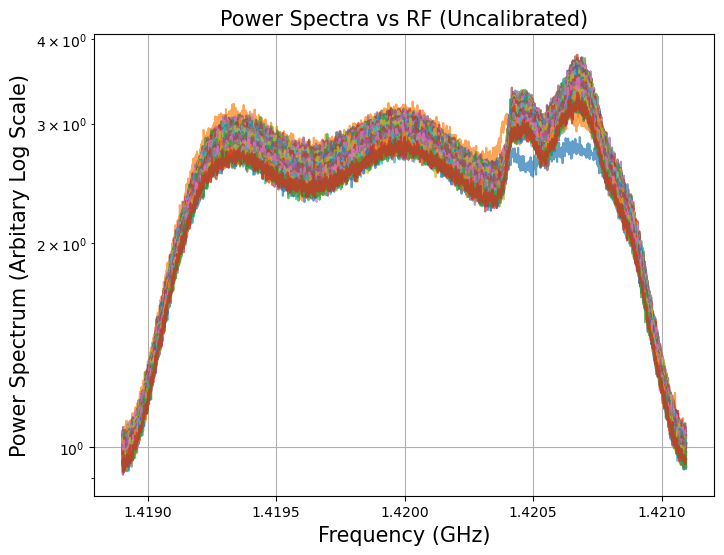

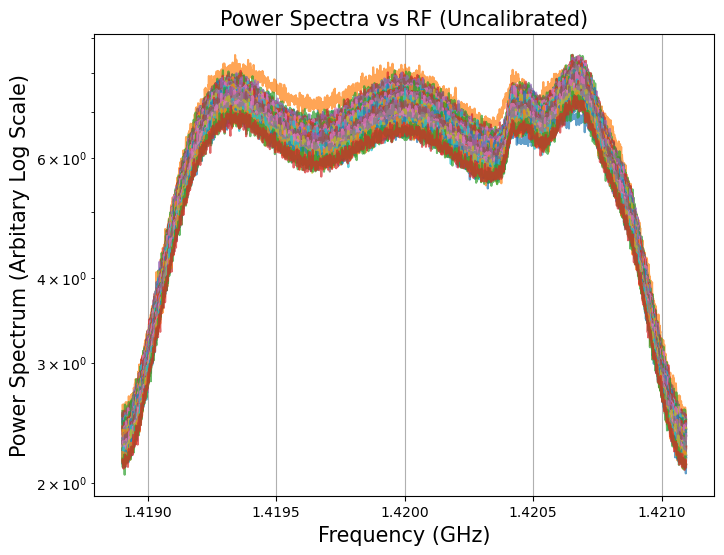

In [ ]:
LO = 1420e6
B = 12e6
SAMPLE_RATE = 2.2e6
WINDOW = 2048
LOW, HIGH = LO - (B // 2), LO + (B // 2)
bounds = (2, -4)

def plot_power_spectrum(data, labels, normalize=False, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    freqs = fftfreq(WINDOW, 1/SAMPLE_RATE) + LO
    freqs = fftshift((freqs))[bounds[0]:bounds[1]]
    
    for spectrum, label in zip(data, labels):
        spectrum = spectrum - np.mean(spectrum) if normalize else spectrum
        spectrum = fftshift(spectrum[bounds[0]:bounds[1]])
        plt.plot(freqs / 1e9, spectrum / 4e3, label=f"Observation Point {label}", alpha=0.7)
    plt.xlabel("Frequency (GHz)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitary Log Scale)", fontsize=axisSize)
    plt.yscale("log")
    plt.xlim(xlim)
    plt.ylim(ylim)
    #plt.legend(fontsize=legendSize)
    title_label = "(Normalized)" if normalize else "(Uncalibrated)"
    plt.title(f"Power Spectra vs RF {title_label}", size=titleSize)
    plt.grid()
    plt.show()


plot_power_spectrum(sdr_data[0], points)
plot_power_spectrum(sdr_data[1], points)


In [ ]:
online, offline = [], [] # Temp for coding

def onlineOfflineSpectra(USB, LSB):
    power_on = np.zeros()